In [1]:
#!/usr/bin/python3
# coding: utf-8
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences
from scipy import interpolate
#import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy import optimize
from astropy.timeseries import LombScargle
import glob
from matplotlib import rc, rcParams
from scipy import special
from scipy.stats import binned_statistic
from astropy.stats import sigma_clip

# Params of plot

In [2]:
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 6
rcParams['grid.linestyle'] = '--'
rcParams['axes.titlepad'] = 20
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rc('legend', fontsize=15)
rc('xtick.major', size=5, width=1.5)
rc('ytick.major', size=5, width=1.5)
rc('xtick.minor', size=3, width=1)
rc('ytick.minor', size=3, width=1)

# Funtions

In [4]:
def flare_cut(mag, time, err):
    main_peak = [np.argmax(mag)]
    _,_,left_ind, right_ind = peak_widths(mag, main_peak, rel_height=0.6)
    left_ind = math.floor(left_ind[0])
    right_ind = math.ceil(right_ind[0])
    print(left_ind, main_peak[0], right_ind)
    print(time[left_ind], time[right_ind])
    
    print('len_mag:', len(mag))
    outl_out = sigma_clip(mag, sigma=2, maxiters=5)
    print('len_mag_clean:', len(outl_out))
    bg1 = np.average(outl_out, weights=1/err)
    print('bg1: ', bg1)
    bg2 = np.mean(mag[-100:-1])
    print('bg2: ',bg2)
    bg = bg1
    half = (mag[main_peak[0]]-bg)/2
    mag = mag - bg
    
    f = interpolate.interp1d(time[left_ind:main_peak[0]+1], mag[left_ind:main_peak[0]+1]-half)
    eq1 = np.linspace(time[left_ind], time[main_peak[0]], 200)
    time_l = eq1[np.argmin(np.abs(f(eq1) - 0))]
    print(time_l)
    
    g = interpolate.interp1d(time[main_peak[0]:right_ind+1], mag[main_peak[0]:right_ind+1]-half)
    eq2 = np.linspace(time[main_peak[0]],time[right_ind], 200)
    time_r = eq2[np.argmin(np.abs(g(eq2) - 0))]
    print(time_r)
    
    wdth = time_r - time_l
    print('FWHM = ', wdth)
    
    flux_bg = mag - bg
    time_cut = np.array(time[(time > time[main_peak[0]]-wdth*4) & (time < time[main_peak[0]]+wdth*20)])
    flux_cut = np.array(flux_bg[(time > time[main_peak[0]]-wdth*4) & (time < time[main_peak[0]]+wdth*20)])
    err_cut = np.array(err[(time > time[main_peak[0]]-wdth*4) & (time < time[main_peak[0]]+wdth*20)])
    cut_peak = np.argmax(flux_cut)
    print(err_cut[0:10])
    return time_cut, flux_cut, err_cut, wdth, time_l, time_r, half, bg, cut_peak

In [5]:

def flare_eqn(t,tpeak,fwhm,ampl):
    '''
    The equation that defines the shape for the Continuous Flare Model
    '''
    #Values were fit & calculated using MCMC 256 walkers and 30000 steps

    A,B,C,D1,D2,f1 = [0.9687734504375167,-0.251299705922117,0.22675974948468916,
                      0.15551880775110513,1.2150539528490194,0.12695865022878844]

    # We include the corresponding errors for each parameter from the MCMC analysis

    A_err,B_err,C_err,D1_err,D2_err,f1_err = [0.007941622683556804,0.0004073709715788909,0.0006863488251125649,
                                              0.0013498012884345656,0.00453458098656645,0.001053149344530907 ]

    f2 = 1-f1

    eqn = ((1 / 2) * np.sqrt(np.pi) * A * C * f1 * np.exp(-D1 * t + ((B / C) + (D1 * C / 2)) ** 2)
                        * special.erfc(((B - t) / C) + (C * D1 / 2))) + ((1 / 2) * np.sqrt(np.pi) * A * C * f2
                        * np.exp(-D2 * t+ ((B / C) + (D2 * C / 2)) ** 2) * special.erfc(((B - t) / C) + (C * D2 / 2)))
    return eqn * ampl


def flare_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Continuous Flare Model evaluated for single-peak (classical) flare events.
    Use this function for fitting classical flares with most curve_fit
    tools.
    References
    --------------
    Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Jackman et al. (2018) https://arxiv.org/abs/1804.03377
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The center time of the flare peak
    fwhm : float
        The Full Width at Half Maximum, timescale of the flare
    ampl : float
        The amplitude of the flare
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
        A continuous flare template whose shape is defined by the convolution of a Gaussian and double exponential
        and can be parameterized by three parameters: center time (tpeak), FWHM, and ampitude
    '''

    t_new = (t-tpeak)/fwhm

    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new) - dt, max(t_new) + dt, t_new.size * uptime)

        flareup = flare_eqn(timeup,tpeak,fwhm,ampl)

        # and now downsample back to the original time...

        downbins = np.concatenate((t_new - dt / 2.,[max(t_new) + dt / 2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:

        flare = flare_eqn(t_new,tpeak,fwhm,ampl)

    return flare

# Half time/Amplitude

In [214]:
# df1 = pd.read_csv('/home/nastya/Downloads/726209400028833.csv')
# df2 = pd.read_csv('/home/nastya/Downloads/762201400007313.csv')
# df3 = pd.read_csv('/home/nastya/Downloads/719216300003437.csv')

id = 762201400007313

#678210100002177
#718201300005383
#719206100008051
#677206300030165

#726209400028833   -- not working
#257209100009778
#437212300061643
#592208400030991
#634207400007102
#676211100006667   -- not working
#685205100007414
#718201300005383   -- not working
#719216300003437   -- not working
#764203100012551
#825213100013108   -- not working

df1 = pd.read_csv('/home/nastya/Downloads/' + str(id) +'.csv')
#df1 = pd.read_csv('/home/nastya/Downloads/634207400007102.csv')

# df2 = pd.read_csv('762201400007313.csv')
# df3 = pd.read_csv('719216300003437.csv')


print('a')
red_data1 = df1.loc[df1['filter'] == 'zr']
green_data1 = df1.loc[df1['filter'] == 'zg']
ir_data1 = df1.loc[df1['filter'] == 'zi']


print('b')

# red_data2 = df2.loc[df1['filter'] == 'zr']
# green_data2 = df2.loc[df1['filter'] == 'zg']
# ir_data2 = df2.loc[df1['filter'] == 'zi']

# red_data3 = df3.loc[df1['filter'] == 'zr']
# green_data3 = df3.loc[df1['filter'] == 'zg']
# ir_data3 = df3.loc[df1['filter'] == 'zi']

flux1 = 10**(-0.4*(red_data1['mag'] - 8.9))
dat1 = red_data1['mjd'] - 58000
err1 = (np.log(10)/2.5)*flux1*red_data1['magerr']   # (np.log(10)/2.5) - this koef = 0.92

print('c')

# mag2 = 10**(-0.4*red_data2['mag'])
# dat2 = red_data2['mjd'] - 58000

# mag3 = 10**(-0.4*red_data3['mag'])
# dat3 = red_data3['mjd'] - 58000

time1, flux_1, error1, width1, left_time1, right_time1, half1, bg1, ind_peak1 = flare_cut(flux1, dat1, err1)
# width2, left_time2, right_time2, half2, bg2, ind_peak2 = flare_cut(mag2, dat2)
# width3, left_time3, right_time3, half3, bg3, ind_peak3 = flare_cut(mag3, dat3)


new_time1 = np.linspace(time1[0], time1[len(time1)-1], 500)
flux_new = flare_model(new_time1, time1[ind_peak1], width1, flux_1[ind_peak1], upsample=False, uptime=10)

#time1 = (dat1-dat1[ind_peak1])/width1
# time2 = (dat2-dat2[ind_peak2])/width2
# time3 = (dat3-dat3[ind_peak3])/width3


# mag2 = mag2-bg2
# mag3 = mag3-bg3


#sns.set()
#plt.plot(x, f(x),'o', c='pink')

#plt.xlim(-2, 4)
plt.figure(figsize = (8,6))
plt.plot(new_time1, flux_new, c='hotpink', label = 'template')
#plt.plot(time1, flux1, 'o', c='c')
plt.errorbar(time1, flux_1, yerr=error1, fmt = 'o', alpha = 0.6, ecolor = 'teal', elinewidth = 2, capsize=4, label='exp_points')
plt.title('Id: '+ str(id))
# plt.plot(time2, mag2/np.max(mag2),'o', c='b')
# plt.plot(time3, mag3/np.max(mag3),'o', c='hotpink')

#plt.plot(dat3, mag3-bg3,'o', c='hotpink', alpha = 0.9)
# plt.hlines(half, left_time, right_time, color='b')
# plt.xlabel('period (days)')
# plt.ylabel('flux')
plt.grid()
plt.xlabel('period, days')
plt.ylabel('flux, Jy')

#plt.plot(mag1, 'o', c = 'pink')

#plt.plot(dat1[main_peak], mag1[main_peak], "x", c='r')

#plt.vlines(x=dat1[main_peak], ymin=contour_heights, ymax=mag1[main_peak], color='b')
#plt.gca().invert_yaxis()
plt.show()


a
b
c
674 675 676
324.1881131483169 324.1991892037913
len_mag: 1599
len_mag_clean: 1599
bg1:  4.890178597730895e-05
bg2:  6.017500620918903e-05


ValueError: A value in x_new is below the interpolation range.

a
0.006975351718270211


<IPython.core.display.Javascript object>


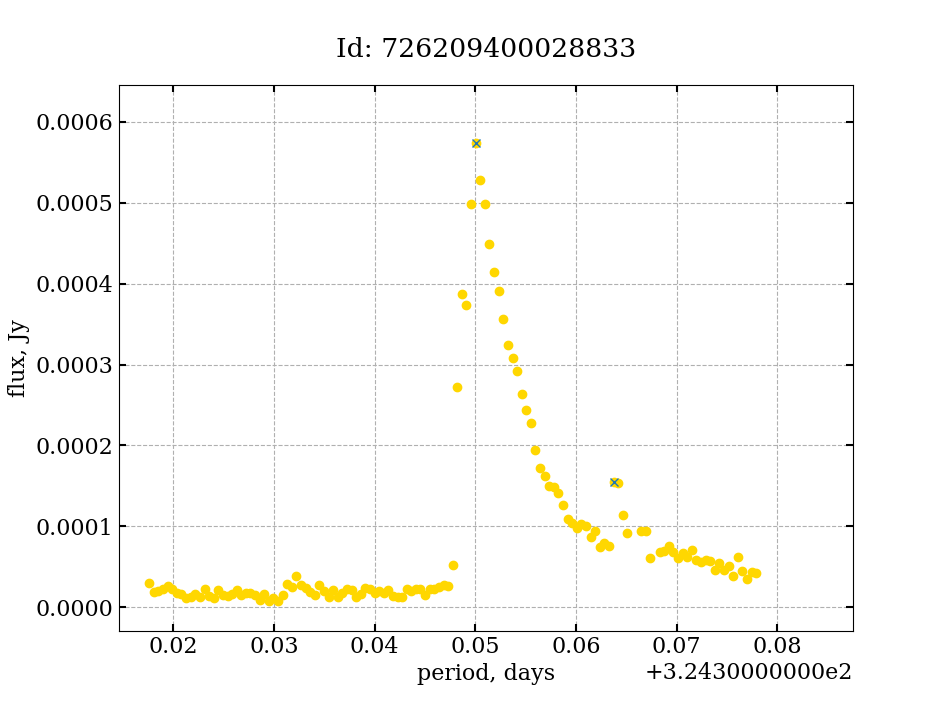

Text(0, 0.5, 'flux, Jy')

In [16]:
id =  726209400028833 

#678210100002177
#718201300005383
#719206100008051
#677206300030165

#726209400028833   -- not working
#257209100009778
#437212300061643
#592208400030991
#634207400007102
#676211100006667   -- not working
#685205100007414
#718201300005383   -- not working
#719216300003437   -- not working
#764203100012551
#825213100013108   -- not working

df1 = pd.read_csv('/home/nastya/Downloads/' + str(id) +'.csv')


print('a')
red_data1 = df1.loc[df1['filter'] == 'zr']
green_data1 = df1.loc[df1['filter'] == 'zg']
ir_data1 = df1.loc[df1['filter'] == 'zi']

flux1 = 10**(-0.4*(red_data1['mag'] - 8.9))
dat1 = red_data1['mjd'] - 58000
err1 = (np.log(10)/2.5)*flux1*red_data1['magerr']   # (np.log(10)/2.5) - this koef = 0.92

flux1 = np.array(flux1)
dat1 = np.array(dat1)
outl_out = sigma_clip(flux1, sigma=2, maxiters=5)

bg1 = np.average(outl_out, weights=1/err1)
std = np.std(outl_out)

flux = flux1 - bg1
print(std/np.max(flux))
peaks, _ = find_peaks(flux, height = std*15, distance = 20, prominence = np.max(flux)/20)  #, threshold = (np.max(flux1)-bg1)/20  , height=(np.max(flux1)-bg1)+bg1
plt.figure(figsize = (8,6))
plt.plot(dat1, flux, 'o', c = 'gold')
plt.plot(dat1[peaks], flux[peaks], "x")
plt.title('Id: '+ str(id))
plt.grid()
plt.xlabel('period, days')
plt.ylabel('flux, Jy')

<IPython.core.display.Javascript object>


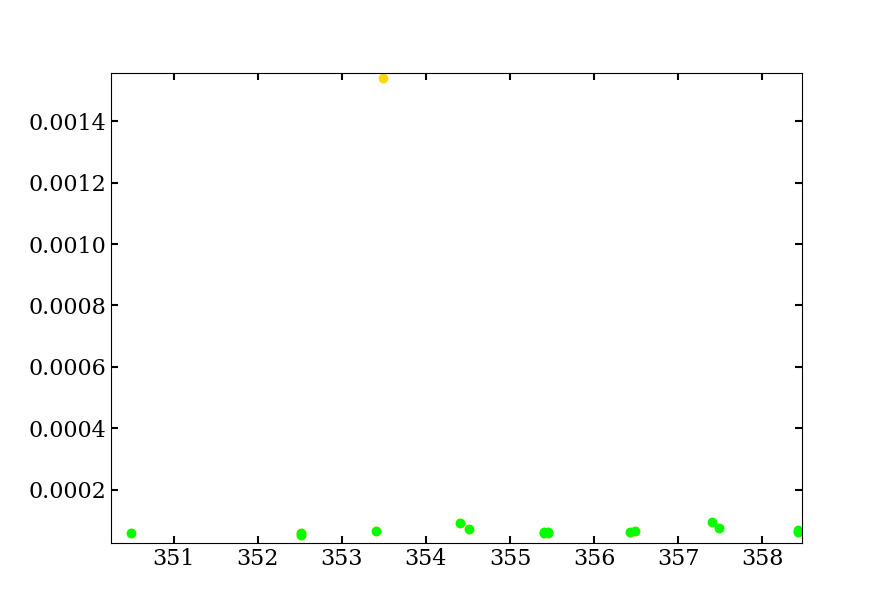

In [55]:
outl_out = sigma_clip(flux1, sigma=5, maxiters=5)

plt.plot(dat1, flux1,  'o', c = 'gold')
plt.plot(dat1, outl_out, 'o', c = 'lime')

In [36]:
t1 = date_scaled 
Frise = 1 + 1.941*t1 - 0.175*t1**2 - 2.246*t1**3 - 1.125*t1**4
Frise_lim1_ind = np.argmin(np.abs(Frise - 1))
Frise_lim2_ind = np.argmin(np.abs(Frise - 0))
Frise_lim1_ind, Frise_lim2_ind


NameError: name 'date_scaled' is not defined

In [ ]:
t2 = date_scaled 
#date_scaled.iloc[128]
Fdecay = 0.6890*np.exp(-1.600*t2) + 0.3030*np.exp(-0.2783*t2)
Fdecay
Fdecay_lim1_ind = np.argmin(np.abs(Fdecay - 7))
Fdecay_lim2_ind = np.argmin(np.abs(Fdecay - 0))
Fdecay_lim1_ind, Fdecay_lim2_ind

In [ ]:
sns.set(rc={'figure.figsize':(9,6)})
#sns.set()
#plt.xlim(-1, 1)
#plt.gca().invert_yaxis()
plt.plot(date_scaled, flux_norm, 'o')
plt.plot(date_scaled.iloc[58:72], Frise.iloc[58:72])
plt.plot(date_scaled.iloc[71:128], Fdecay[71:128])
plt.xlabel('scaled time')
plt.ylabel('relative flux')
#plt.plot(date, np.ones(130)*0.5)
#plt.plot(peaks, flux_norm[peaks], "x")
#plt.hlines(*results_half[1:], color="C2")
#plt.legend('ABCDEF', ncol=2, loc='upper left');
plt.show()

In [ ]:
df = pd.read_csv('/home/nastya/Downloads/726209400028833.csv')


period_pl = df.truncate(before=220, after=285)
new_date = period_pl['mjd']
new_mag = period_pl['mag']

# rand = np.random.default_rng(42)

# t = 100 * rand.random(100)

# y = np.sin(0.06 * np.pi * t) + 0.001 * rand.standard_normal(100)

sns.set(rc={'figure.figsize':(9,6)})
#sns.set()
#plt.xlim(-1, 1)
plt.gca().invert_yaxis()
plt.plot(new_date-58000, new_mag, 'o')
#plt.plot(t, y, 'o')
#plt.plot(peaks, flux_norm[peaks], "x")
#plt.hlines(*results_half[1:], color="C2")
#plt.legend('ABCDEF', ncol=2, loc='upper left');
plt.show()

In [ ]:
from astropy.timeseries import LombScargle


frequency, power = LombScargle(new_date, new_mag).autopower()
sns.set()
plt.xlabel('period (days)')
plt.ylabel('power')
plt.plot(1/frequency, power)   
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [ ]:
#image_file = get_pkg_data_filename('ztf_20181216240937_000803_zr_c06_o_q2_sciimg.fits')
image_file = get_pkg_data_filename('ztf_20181127232303_000803_zr_c06_o_q2_sciimg.fits')
#image_file = get_pkg_data_filename('ztf_20180819323090_000803_zr_c06_o_q2_sciimg.fits')
fits.info(image_file)

In [ ]:
image_data = fits.getdata(image_file, ext=0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()